# Lorenzモデル

l63vdaからコピー。改良オイラーは省略。

In [1]:
def florenz(w, p, r, b):
    x, y, z = w
    dw = np.zeros_like(w)
    dw[0] =      -p * x + p * y 
    dw[1] = (r - z) * x -     y 
    dw[2] =           x * y     - b * z
    return dw

# 真値の作成

観測誤差10%を`e`に入れておく。

In [2]:
p, r, b, dt = 10, 32, 8/3, 0.01
nstop = 200
obs_int = 60

w = np.array([1.0, 3.0, 5.0])
e = w * 0.1
x_obs = np.zeros([nstop//obs_int, w.size])
x_obs[0, :] = w
x = np.zeros([nstop+1, w.size])
for i in range(1, nstop+1):
    w += dt * florenz(w, p, r, b)
    x[i, :] = w
np.save("xt.npy", x)

# アンサンブルフィルタ

摂動行列を使わない式通りの素朴な定義。アンサンブルランの関数も定義しておく。

In [3]:
def po(xf, yo, rmat, hmat):
    dx = xf - np.mean(xf, axis=1)[:, None]
    pf = dx @ dx.transpose() / (nmem - 1)
    ic = hmat @ pf @ hmat.transpose() + rmat
    kmat = pf @ hmat.transpose() @ np.linalg.inv(ic)   
    xa = xf + kmat @ (yo - hmat @ xf)
    return xa

def run_ens(xf, p, r, b, nstop):
    _, nmem = xf.shape
    for i in range(nmem):
        w = xf[:, i]
        for k in range(nstop):
            w += dt * florenz(w, p, r, b)
        xf[:, i] = w           
    return xf

# 同化実験

観測演算子は単位行列，観測誤差共分散は対角。

In [4]:
nmem = 3
xs = 3.0

hmat = np.eye(w.size)
rmat = np.diag(e**2)

xtrue = np.load("xt.npy")
w = np.array([1, -3, 5])
rng = np.random.default_rng()
xf = np.zeros([w.size, nmem])
for i in range(w.size):
    xf[i, :] = w[i, None] + xs * rng.standard_normal(nmem)
np.save("xf000.npy", xf)
yo = np.zeros([w.size, nmem])
for j in range(nstop//obs_int):
    for i in range(w.size):
        yo[i, :] = xtrue[obs_int*(j+1), i] + e[i] * rng.standard_normal(nmem)
    xf = run_ens(xf, p, r, b, obs_int)
    np.save(f"xf{obs_int*(j+1):03}.npy", xf)
    xa = po(xf, yo, rmat, hmat)
    np.save(f"xa{obs_int*(j+1):03}.npy", xa)
    xf = xa

# 結果

〇はアンサンブル予報，×は予報アンサンブル平均，赤丸は解析値（解析アンサンブル平均），線は真値

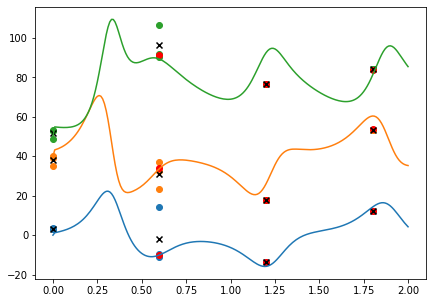

In [5]:
import matplotlib.pyplot as plt


off = 0, 40, 50

x = np.linspace(0, dt*nstop, nstop+1)
wtrue = np.copy(xtrue)
wtrue[:, 1] += off[1]            
wtrue[:, 2] += off[2]
fig, ax = plt.subplots(figsize=[7, 5])
ax.plot(x, wtrue)
xf = np.load("xf000.npy")
xf_mean = np.mean(xf, axis=1)
ax.set_prop_cycle(None)
for i in range(len(off)):
    ax.scatter([0]*nmem, xf[i, :] + off[i])
for i in range(len(off)):
    ax.scatter(0, xf_mean[i] + off[i], c="black", marker="x")
for j in range(nstop//obs_int):
    ax.set_prop_cycle(None)
    xf = np.load(f"xf{obs_int*(j+1):03}.npy")
    xf_mean = np.mean(xf, axis=1)
    xa = np.load(f"xa{obs_int*(j+1):03}.npy")
    xa_mean = np.mean(xa, axis=1)
    t = obs_int*(j+1) * dt
    tnmem = [t] * nmem
    for i in range(len(off)):
        ax.scatter(tnmem, xf[i, :] + off[i])
    for i in range(len(off)):
        ax.scatter(t, xa_mean[i] + off[i], c="red")
    for i in range(len(off)):
        ax.scatter(t, xf_mean[i] + off[i], c="black", marker="x")